In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch

In [2]:
## COPIED FROM TESTING_PARALLEL.PY
NORM_ALPHA = 0.9
def norm_jm(fitem, fnode, fcoll):
    fitem_div = fitem / fitem.sum()
    fnode_div = fnode / fnode.sum()
    fcoll_div = fcoll / fcoll.sum()
    norm = NORM_ALPHA * fitem_div + (1 - NORM_ALPHA) * fnode_div * fcoll_div
    return norm

## read in the dataset
df = pd.read_csv("stimuli.csv")  # same dataset as MSc project
dataset = df[["item", "item_pt"]]

# convert comma-sep number strings to numbers
_coll_freq_en = df[["fitem", "fnode", "fcoll"]].applymap(
    lambda x: float(str(x).replace(",", ""))
)
# no replacement because it's actually numbers
_coll_freq_pt = df[["fitempt", "fnodept", "fcollpt"]].astype(float)

norm_freq_en = norm_jm(_coll_freq_en["fitem"], _coll_freq_en["fnode"], _coll_freq_en["fcoll"])
norm_freq_pt = norm_jm(
    _coll_freq_pt["fitempt"], _coll_freq_pt["fnodept"], _coll_freq_pt["fcollpt"]
)


In [3]:
# set the random seeds for reproducibility
import random
import pickle

random.seed(0)
torch.manual_seed(0)
np.random.seed(0)

M = 10000


def get_colloc2BERT(filename):
    with open(filename, "rb") as f:
        colloc2BERT = pickle.load(f)
        print(f"Read from file {filename}")
    return colloc2BERT


bert_embeddings_cache_filename_en = f"colloc2BERT-stimuli-lang_en-concat.dat"
bert_embeddings_cache_filename_pt = f"colloc2BERT-stimuli-lang_pt-concat.dat"

colloc2BERT_en = get_colloc2BERT(bert_embeddings_cache_filename_en)
colloc2BERT_pt = get_colloc2BERT(bert_embeddings_cache_filename_pt)

Read from file colloc2BERT-stimuli-lang_en-concat.dat
Read from file colloc2BERT-stimuli-lang_pt-concat.dat


In [4]:
alsla_results = pd.read_csv("ALSLA-results.csv")
# get unique by item
alsla_results = alsla_results.drop_duplicates(subset="item")[["item", "collType"]]
# join with dataset on item
df_expanded = df.merge(alsla_results.set_index("item"), on="item")

df_expanded["bert_en"] = list(colloc2BERT_en.values())
df_expanded["bert_pt"] = list(colloc2BERT_pt.values())

df_expanded["norm_freq_en"] = norm_freq_en
df_expanded["norm_freq_pt"] = norm_freq_pt

df_expanded = df_expanded[df_expanded["collType"] != "baseline"]
df_expanded

,trialType,item,item_pt,length,syllables,node,fnode,knode,coll,fcoll,...,fitempt,nodept,fnodept,collpt,fcollpt,collType,bert_en,bert_pt,norm_freq_en,norm_freq_pt
1,target,show love,mostrar amor,8,2,show,"13,781,511",1,love,"3,718,645",...,1636,mostrar,3780818,amor,2002557,cc,"[tensor(0.0813), tensor(-5.5075), tensor(-0.61...","[tensor(3.4594), tensor(0.6212), tensor(-0.387...",0.013568,1.069295e-02
3,target,fly flags,voar bandeiras,8,2,fly,"1,645,632",1,flags,"804,940",...,0,voar,238243,bandeiras,85803,eo,"[tensor(-0.0530), tensor(-2.0317), tensor(1.47...","[tensor(0.7448), tensor(0.2496), tensor(1.6686...",0.006456,3.129020e-07
4,target,buy tickets,comprar bilhetes,10,3,buy,"5,173,981",1,tickets,"1,386,678",...,2935,comprar,2256382,bilhetes,51879,fc,"[tensor(1.6520), tensor(-1.4132), tensor(1.840...","[tensor(0.1073), tensor(-1.0990), tensor(-0.41...",0.051436,1.897713e-02
7,target,walk dogs,andar cães,9,2,walk,"3,471,332",1,dogs,"2,934,904",...,2,andar,1312827,cães,231347,eo,"[tensor(-0.7766), tensor(-2.1999), tensor(1.77...","[tensor(-1.6629), tensor(-0.5949), tensor(2.34...",0.009505,1.757936e-05
9,target,sing songs,cantar canções,9,2,sing,"1,043,798",1,songs,"2,828,167",...,4635,cantar,535722,canções,186654,fc,"[tensor(-0.8197), tensor(-2.9131), tensor(-0.3...","[tensor(0.9053), tensor(-0.5930), tensor(1.357...",0.052734,2.996770e-02
11,target,burn coal,queimar carvão,8,2,burn,"1,082,445",1,coal,"626,842",...,190,queimar,312801,carvão,87905,fc,"[tensor(-0.3319), tensor(-2.0711), tensor(0.64...","[tensor(0.1477), tensor(-2.5630), tensor(-1.51...",0.006563,1.228807e-03
12,target,build houses,construir casas,11,3,build,"8,137,945",1,houses,"5,281,006",...,13162,construir,1511819,casas,604689,fc,"[tensor(1.4198), tensor(-1.3639), tensor(0.054...","[tensor(0.8250), tensor(-1.2554), tensor(2.944...",0.057506,8.510885e-02
14,target,drink beer,beber cerveja,9,2,drink,"1,073,722",1,beer,"805,681",...,3862,beber,927124,cerveja,268845,fc,"[tensor(0.4455), tensor(-1.7812), tensor(-0.46...","[tensor(0.2869), tensor(-1.5261), tensor(-0.93...",0.008372,2.497239e-02
17,target,mask smells,disfarçar cheiros,10,2,mask,"146,513",2,smells,"362,131",...,172,disfarçar,106391,cheiros,17178,cc,"[tensor(-1.1441), tensor(-3.3581), tensor(-0.2...","[tensor(1.1253), tensor(-0.7160), tensor(-0.02...",0.000182,1.112041e-03
19,target,keep promises,manter compromissos,12,4,keep,"11,071,432",1,promises,"1,017,910",...,2307,manter,3245677,compromissos,159460,cc,"[tensor(-0.2743), tensor(-1.6113), tensor(1.12...","[tensor(0.5945), tensor(-0.6606), tensor(1.532...",0.012893,1.492312e-02


In [5]:
colloc_bert_embeddings_en = torch.stack(df_expanded["bert_en"].tolist())
colloc_bert_embeddings_pt = torch.stack(df_expanded["bert_pt"].tolist())

In [6]:
len(df_expanded["bert_en"])

45

In [7]:
from typing import Literal


# L = 0.6  # 0.6 is what the meta paper says
freq_fraction_pt = 0.6


def get_sampled_matrix(lang: Literal["en", "pt"], freq_lang: Literal["en", "pt", "mix"], noise_threshold=0.0):
    # sample from the collocations to make a M x 768 matrix
    sample_k = M - len(colloc_bert_embeddings_en)
    _colloc_bert_embeddings = (
        colloc_bert_embeddings_en if lang == "en" else colloc_bert_embeddings_pt
    )

    if freq_lang == "en":
        sampled_collocs = torch.stack(
            random.choices(_colloc_bert_embeddings, k=sample_k, weights=df_expanded["norm_freq_en"])
        )
    elif freq_lang == "pt":
        sampled_collocs = torch.stack(
            random.choices(_colloc_bert_embeddings, k=sample_k, weights=df_expanded["norm_freq_pt"])
        )
    elif freq_lang == "mix":
        sample_k_pt = round(sample_k * freq_fraction_pt)
        sample_k_en = sample_k - sample_k_pt
        _sampled_collocs_pt = torch.stack(
            random.choices(colloc_bert_embeddings_en, k=sample_k_pt, weights=df_expanded["norm_freq_pt"])
        )
        _sampled_collocs_en = torch.stack(
            random.choices(colloc_bert_embeddings_en, k=sample_k_en, weights=df_expanded["norm_freq_en"])
        )
        sampled_collocs = torch.concat([_sampled_collocs_pt, _sampled_collocs_en], dim=0)

    matrix = torch.concat([_colloc_bert_embeddings, sampled_collocs], dim=0)

    embed_dim = 768 * 2

    assert matrix.size() == (M, embed_dim), "Huh?"

    noise_gaussian = torch.normal(0, 1, (M, embed_dim))
    noise_mask = torch.rand((M, embed_dim))  # noise is a tensor of random numbers between 0 and 1
    noisy_mem = torch.where(
        noise_mask < noise_threshold, matrix + noise_gaussian, matrix
    )  # if the noise is less than L, then add gaussian noise, otherwise it is the original matrix

    return noisy_mem

In [8]:
noise_threshold = 0.6

en_en_matrix = get_sampled_matrix("en", "en", noise_threshold=noise_threshold)
pt_pt_matrix = get_sampled_matrix("pt", "pt", noise_threshold=noise_threshold)

In [9]:
colloc_bert_embeddings_en.shape

torch.Size([45, 1536])

In [10]:
from typing import List


def get_query_sims(query_vectors, matrix):
    sims = [
        torch.cosine_similarity(v.unsqueeze(0), matrix, dim=-1) for v in query_vectors
    ]
    return torch.stack(sims)

print(colloc_bert_embeddings_en.shape, en_en_matrix.shape)

en_sims = get_query_sims(colloc_bert_embeddings_en, en_en_matrix)
pt_sims = get_query_sims(colloc_bert_embeddings_pt, pt_pt_matrix)
print(en_sims.shape, pt_sims.shape)

torch.Size([45, 1536]) torch.Size([10000, 1536])
torch.Size([45, 10000]) torch.Size([45, 10000])


In [11]:
def get_familiarities(sims: torch.Tensor):
    # familiarity is the average cosine similarity between the query vector
    # and the matrix
    # compute familiarities for every query vector
    familiarity = sims.mean(dim=1)
    return familiarity

en_familiarities = get_familiarities(en_sims)
pt_familiarities = get_familiarities(pt_sims)

df_expanded["familiarity_en"] = en_familiarities
df_expanded["familiarity_pt"] = pt_familiarities

In [12]:
df_expanded

,trialType,item,item_pt,length,syllables,node,fnode,knode,coll,fcoll,...,fnodept,collpt,fcollpt,collType,bert_en,bert_pt,norm_freq_en,norm_freq_pt,familiarity_en,familiarity_pt
1,target,show love,mostrar amor,8,2,show,"13,781,511",1,love,"3,718,645",...,3780818,amor,2002557,cc,"[tensor(0.0813), tensor(-5.5075), tensor(-0.61...","[tensor(3.4594), tensor(0.6212), tensor(-0.387...",0.013568,1.069295e-02,0.790851,0.576369
3,target,fly flags,voar bandeiras,8,2,fly,"1,645,632",1,flags,"804,940",...,238243,bandeiras,85803,eo,"[tensor(-0.0530), tensor(-2.0317), tensor(1.47...","[tensor(0.7448), tensor(0.2496), tensor(1.6686...",0.006456,3.129020e-07,0.803283,0.588593
4,target,buy tickets,comprar bilhetes,10,3,buy,"5,173,981",1,tickets,"1,386,678",...,2256382,bilhetes,51879,fc,"[tensor(1.6520), tensor(-1.4132), tensor(1.840...","[tensor(0.1073), tensor(-1.0990), tensor(-0.41...",0.051436,1.897713e-02,0.815586,0.586199
7,target,walk dogs,andar cães,9,2,walk,"3,471,332",1,dogs,"2,934,904",...,1312827,cães,231347,eo,"[tensor(-0.7766), tensor(-2.1999), tensor(1.77...","[tensor(-1.6629), tensor(-0.5949), tensor(2.34...",0.009505,1.757936e-05,0.798581,0.585947
9,target,sing songs,cantar canções,9,2,sing,"1,043,798",1,songs,"2,828,167",...,535722,canções,186654,fc,"[tensor(-0.8197), tensor(-2.9131), tensor(-0.3...","[tensor(0.9053), tensor(-0.5930), tensor(1.357...",0.052734,2.996770e-02,0.818586,0.603206
11,target,burn coal,queimar carvão,8,2,burn,"1,082,445",1,coal,"626,842",...,312801,carvão,87905,fc,"[tensor(-0.3319), tensor(-2.0711), tensor(0.64...","[tensor(0.1477), tensor(-2.5630), tensor(-1.51...",0.006563,1.228807e-03,0.807135,0.571228
12,target,build houses,construir casas,11,3,build,"8,137,945",1,houses,"5,281,006",...,1511819,casas,604689,fc,"[tensor(1.4198), tensor(-1.3639), tensor(0.054...","[tensor(0.8250), tensor(-1.2554), tensor(2.944...",0.057506,8.510885e-02,0.815891,0.600945
14,target,drink beer,beber cerveja,9,2,drink,"1,073,722",1,beer,"805,681",...,927124,cerveja,268845,fc,"[tensor(0.4455), tensor(-1.7812), tensor(-0.46...","[tensor(0.2869), tensor(-1.5261), tensor(-0.93...",0.008372,2.497239e-02,0.804685,0.564896
17,target,mask smells,disfarçar cheiros,10,2,mask,"146,513",2,smells,"362,131",...,106391,cheiros,17178,cc,"[tensor(-1.1441), tensor(-3.3581), tensor(-0.2...","[tensor(1.1253), tensor(-0.7160), tensor(-0.02...",0.000182,1.112041e-03,0.768394,0.548171
19,target,keep promises,manter compromissos,12,4,keep,"11,071,432",1,promises,"1,017,910",...,3245677,compromissos,159460,cc,"[tensor(-0.2743), tensor(-1.6113), tensor(1.12...","[tensor(0.5945), tensor(-0.6606), tensor(1.532...",0.012893,1.492312e-02,0.797028,0.590128


<Axes: xlabel='collType', ylabel='familiarity_en'>

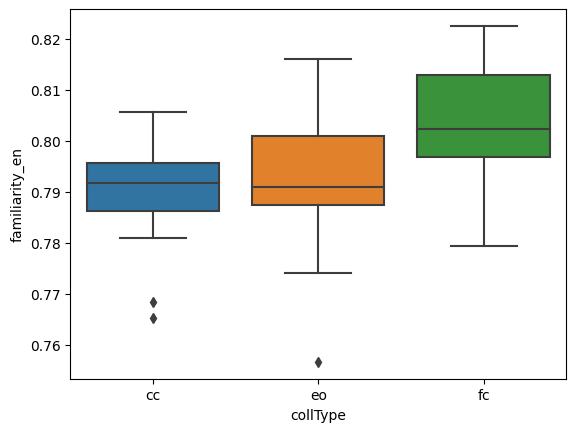

In [13]:
sns.boxplot(x="collType", y="familiarity_en", data=df_expanded)

<Axes: xlabel='collType', ylabel='familiarity_pt'>

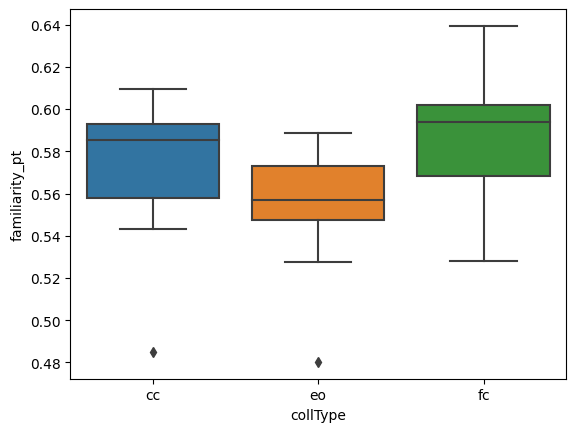

In [14]:
sns.boxplot(x="collType", y="familiarity_pt", data=df_expanded)

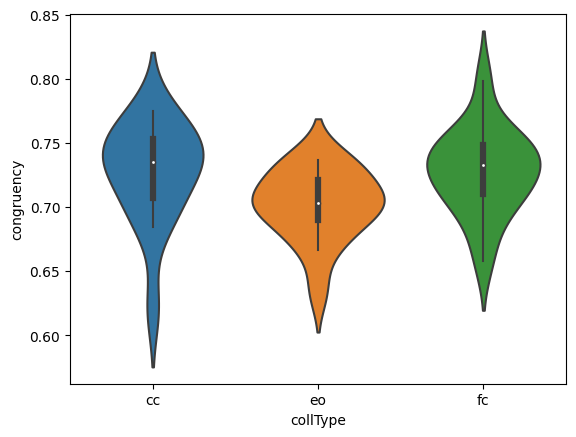

In [33]:
def get_congruency(familiarities1, familiarities2):
    # congruency is the difference between the familiarities of the two languages
    congruency = familiarities1 / familiarities2
    return congruency

congruency = get_congruency(pt_familiarities, en_familiarities)

# plot congruency vs collType
df_expanded["congruency"] = congruency

# # minmax norm congruency
# df_expanded["congruency"] = (df_expanded["congruency"] - df_expanded["congruency"].min()) / (
#     df_expanded["congruency"].max() - df_expanded["congruency"].min()
# )

# filter waste time
# no_waste_time_df = df_expanded[df_expanded["item"]!="waste time"]

sns.violinplot(x="collType", y="congruency", data=df_expanded)
plt.show()

In [ ]:
def get_sem_transparency(sims: torch.Tensor):
    # familiarity is the average cosine similarity between the query vector
    # and the matrix
    # compute semantic transparency for every query vector
    familiarity = sims.mean(dim=1)
    return familiarity

en_sem_transparencies = get_sem_transparency(en_sims)
pt_sem_transparencies = get_sem_transparency(pt_sims)

df_expanded["sem_transparency_en"] = en_sem_transparencies
df_expanded["sem_transparency_pt"] = pt_sem_transparencies